## Required libraries


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from dotenv import load_dotenv

# Load environment variables from .env file (expected in this directory)
load_dotenv()

# hana-ml classes
from hana_ml import ConnectionContext
from hana_ml.dataframe import create_dataframe_from_pandas, DataFrame
# Import OutlierDetectionRegression
from hana_ml.algorithms.pal.preprocessing import OutlierDetectionRegression

In [2]:
# --- Connection Setup (Replace with your actual credentials) ---
# Please ensure these environment variables are set or replace the strings directly.
# Assumes .env file is in the current 'regression_anomaly' directory
hana_address = os.getenv('hana_address', "<your_hana_address>")
hana_port = int(os.getenv('hana_port', 443)) # Use int() for port
hana_user = os.getenv('hana_user', "<your_hana_user>")
hana_password = os.getenv('hana_password', "<your_hana_password>")
hana_encrypt = os.getenv('hana_encrypt', 'true').lower() == 'true' # Handle boolean conversion
hana_schema = os.getenv('HANA_SCHEMA', 'AICOE') # Default schema or your specific one

# Establish connection
try:
    cc = ConnectionContext(
        address=hana_address,
        port=hana_port,
        user=hana_user,
        password=hana_password,
        encrypt=hana_encrypt,
        # Add sslValidateCertificate='false' if using self-signed certs and encryption
        # sslValidateCertificate='false',
        current_schema=hana_schema # Set the schema context
    )
    print(f"HANA Connection Test Successful: {cc.hana_version()}")
    print(f"Current Schema: {cc.get_current_schema()}")
except Exception as e:
    print(f"Error connecting to HANA: {e}")
    # Stop execution if connection fails
    raise SystemExit("HANA connection failed, please check credentials and settings.")

# --- Configuration for the Notebook ---
# Name for the HANA table we will create
TABLE_NAME = "SYNTHETIC_REGRESSION_ANOMALY_DATA"
# Path to the generated data file
CSV_FILENAME = 'synthetic_regression_anomaly_data.csv'
# Feature columns from the generator script
FEATURE_COLS = [f'feature_{i+1}' for i in range(5)]
# Target column
TARGET_COL = 'target'
# Ground truth column from the generator script
TRUTH_COL = 'is_anomaly'
# Anomaly type column
ANOMALY_TYPE_COL = 'anomaly_type'

HANA Connection Test Successful: 4.00.000.00.1733217781 (fa/CE2024.28)
Current Schema: AICOE


# Regression Outlier Detection with hana-ml

**Objective:** This notebook demonstrates how to use the `OutlierDetectionRegression` class provided by the SAP HANA Predictive Analysis Library (PAL) via the `hana-ml` Python client for anomaly detection on a synthetically generated regression dataset.

**Algorithm Overview:** In regression, an outlier is a data point that differs significantly from the general behavior of the remaining data points. The `OutlierDetectionRegression` algorithm works in two steps:

1. **Residual Extraction:** A regression model (linear or tree-based) is fitted to the data, and residuals are calculated.
2. **Outlier Detection on Residuals:** An outlier detection method is applied to the residuals:
    - For linear models: Uses deleted studentized residuals
    - For tree models: Uses z-scores of residuals

**Key Parameters:**

- `regression_model` (str): 'linear' or 'tree' (default: 'linear')
- `threshold` (float): Threshold for outlier score (default: 3)
  - **For Linear Model:** The threshold is compared against the deleted studentized residual
  - **For Tree Model:** The threshold is compared against the z-score of the residual
- `iter_num` (int): Number of trees for tree model (default: 10)
- `max_depth` (int): Maximum depth for tree model (default: 6)
- `eta` (float): Learning rate for tree model (default: 0.3)


## 1. Data Loading and Preparation

First, we load the synthetic data generated by `regression_anomaly_generator.py` into a pandas DataFrame and then upload it to SAP HANA.

In [3]:
try:
    df_local = pd.read_csv(CSV_FILENAME)
    print(f"Successfully loaded '{CSV_FILENAME}' with shape {df_local.shape}")
except FileNotFoundError:
    print(f"Error: The file '{CSV_FILENAME}' was not found.")
    print("Please ensure the data file exists in the 'regression_anomaly' directory.")
    # Stop execution
    raise SystemExit("Input data file not found.")

# Display basic info and head of the local DataFrame
print("\nLocal DataFrame Info:")
df_local.info()
print("\nLocal DataFrame Head:")
print(df_local.head())
print("\nAnomaly Distribution (Ground Truth):")
print(df_local[TRUTH_COL].value_counts(normalize=True))
print("\nAnomaly Type Distribution:")
print(df_local[ANOMALY_TYPE_COL].value_counts())

# Calculate the actual contamination level
actual_contamination = df_local[TRUTH_COL].mean()
print(f"\nActual contamination in the dataset: {actual_contamination:.4f}")

# Create an ID column for HANA (required for the algorithm)
df_local['ID'] = range(len(df_local))

# --- Upload data to HANA ---
# Drop the table if it exists before creating a new one
try:
    cc.drop_table(TABLE_NAME)
    print(f"Dropped existing table '{TABLE_NAME}'.")
except Exception:
    print(f"Table '{TABLE_NAME}' does not exist yet, proceeding.")

# Create HANA DataFrame from pandas DataFrame
print(f"\nUploading data to HANA table '{TABLE_NAME}'...")
try:
    hdf_input = create_dataframe_from_pandas(
        connection_context=cc,
        pandas_df=df_local,
        table_name=TABLE_NAME,
        force=True,
        replace=True,
        primary_key='ID'
    )
    print(f"Successfully created HANA DataFrame: {hdf_input.count()} rows.")
    # Display info about the HANA DataFrame
    print("\nHANA DataFrame Info (selected columns):")
    print(hdf_input.select('ID', *FEATURE_COLS, TARGET_COL, TRUTH_COL).head(5).collect())

except Exception as e:
    print(f"Error uploading data to HANA: {e}")
    raise SystemExit("Failed to create HANA DataFrame.")

Successfully loaded 'synthetic_regression_anomaly_data.csv' with shape (1000, 8)

Local DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   feature_1     1000 non-null   float64
 1   feature_2     1000 non-null   float64
 2   feature_3     1000 non-null   float64
 3   feature_4     1000 non-null   float64
 4   feature_5     1000 non-null   float64
 5   target        1000 non-null   float64
 6   is_anomaly    1000 non-null   int64  
 7   anomaly_type  1000 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 62.6+ KB

Local DataFrame Head:
   feature_1   feature_2  feature_3  feature_4  feature_5     target  \
0  54.967142  104.411440  21.222809  97.845448  38.126773  66.783489   
1  47.658630   94.001598  20.510203  67.957884  44.340480  21.166725   
2  45.365823   82.738293  16.973442  46.300796  26.200657  

ERROR:hana_ml.dataframe:Fail to drop table. (259, 'invalid table name: SYNTHETIC_REGRESSION_ANOMALY_DATA: line 1 col 20 (at pos 19)')


Dropped existing table 'SYNTHETIC_REGRESSION_ANOMALY_DATA'.

Uploading data to HANA table 'SYNTHETIC_REGRESSION_ANOMALY_DATA'...


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


Successfully created HANA DataFrame: 1000 rows.

HANA DataFrame Info (selected columns):
   ID  feature_1   feature_2  feature_3  feature_4  feature_5     target  \
0   0  54.967142  104.411440  21.222809  97.845448  38.126773  66.783489   
1   1  47.658630   94.001598  20.510203  67.957884  44.340480  21.166725   
2   2  45.365823   82.738293  16.973442  46.300796  26.200657  44.812290   
3   3  44.377125   90.147433  19.622731  61.379639  28.701570  36.298686   
4   4  64.656488  124.916057  30.707878  53.628777  35.644938  82.841295   

   is_anomaly  
0           0  
1           0  
2           0  
3           0  
4           0  


## 2. Running Outlier Detection with Linear Regression Model

Let's start with the linear regression model for outlier detection.

In [4]:
# Instantiate the OutlierDetectionRegression model with linear regression
odr_linear = OutlierDetectionRegression(
    regression_model='linear',
    threshold=3.0  # Default threshold
)

print("OutlierDetectionRegression model instantiated (linear model)")

# Run fit_predict
print("\nRunning fit_predict for regression outlier detection (linear model)...")
try:
    # Fit the model and predict outliers
    results_linear_hdf = odr_linear.fit_predict(
        data=hdf_input,
        key='ID',
        features=FEATURE_COLS,
        label=TARGET_COL
    )
    print("fit_predict completed successfully.")

    # Check the results DataFrame
    if results_linear_hdf:
        print("\nPrediction Results (Linear Model - HANA DataFrame Head):")
        # Collect results into a pandas DataFrame for analysis
        df_results_linear = results_linear_hdf.collect()
        print(df_results_linear.head())

        print("\nPrediction Results Info:")
        df_results_linear.info()
        
        # Check the IS_OUTLIER column distribution
        if 'IS_OUTLIER' in df_results_linear.columns:
            print("\nPredicted Outlier Distribution (Linear Model):")
            print(df_results_linear['IS_OUTLIER'].value_counts())
        else:
            print("\nWarning: 'IS_OUTLIER' column not found in results.")

    else:
        print("fit_predict did not return a results DataFrame.")

except Exception as e:
    print(f"Error during fit_predict: {e}")
    raise SystemExit("fit_predict failed.")

OutlierDetectionRegression model instantiated (linear model)

Running fit_predict for regression outlier detection (linear model)...
fit_predict completed successfully.

Prediction Results (Linear Model - HANA DataFrame Head):
   ID     TARGET   RESIDUAL  OUTLIER_SCORE  IS_OUTLIER
0   0  66.783489   6.894706       0.505312           0
1   1  21.166725 -19.498878      -1.428543           0
2   2  44.812290   9.149462       0.672630           0
3   3  36.298686  -3.104094      -0.227481           0
4   4  82.841295   8.404853       0.616496           0

Prediction Results Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             1000 non-null   int64  
 1   TARGET         1000 non-null   float64
 2   RESIDUAL       1000 non-null   float64
 3   OUTLIER_SCORE  1000 non-null   float64
 4   IS_OUTLIER     1000 non-null   int64  
dtyp

## 3. Evaluating Linear Model Results

Compare the predictions with ground truth.


Merging predictions with ground truth...

Merged DataFrame Head (with truth and prediction):
   ID  is_anomaly  predicted_anomaly  OUTLIER_SCORE   RESIDUAL
0   0           0                  0       0.505312   6.894706
1   1           0                  0      -1.428543 -19.498878
2   2           0                  0       0.672630   9.149462
3   3           0                  0      -0.227481  -3.104094
4   4           0                  0       0.616496   8.404853

--- Classification Report (Linear Model) ---
              precision    recall  f1-score   support

  Normal (0)       0.99      1.00      0.99       970
 Anomaly (1)       1.00      0.60      0.75        30

    accuracy                           0.99      1000
   macro avg       0.99      0.80      0.87      1000
weighted avg       0.99      0.99      0.99      1000


--- Confusion Matrix (Linear Model) ---
[[970   0]
 [ 12  18]]


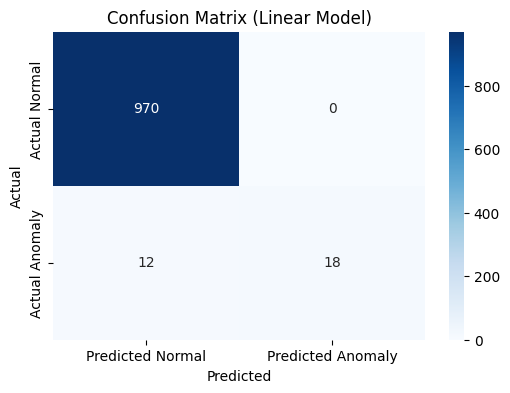


--- Plotting Residuals: Ground Truth vs. Predicted Anomalies (Linear Model) ---


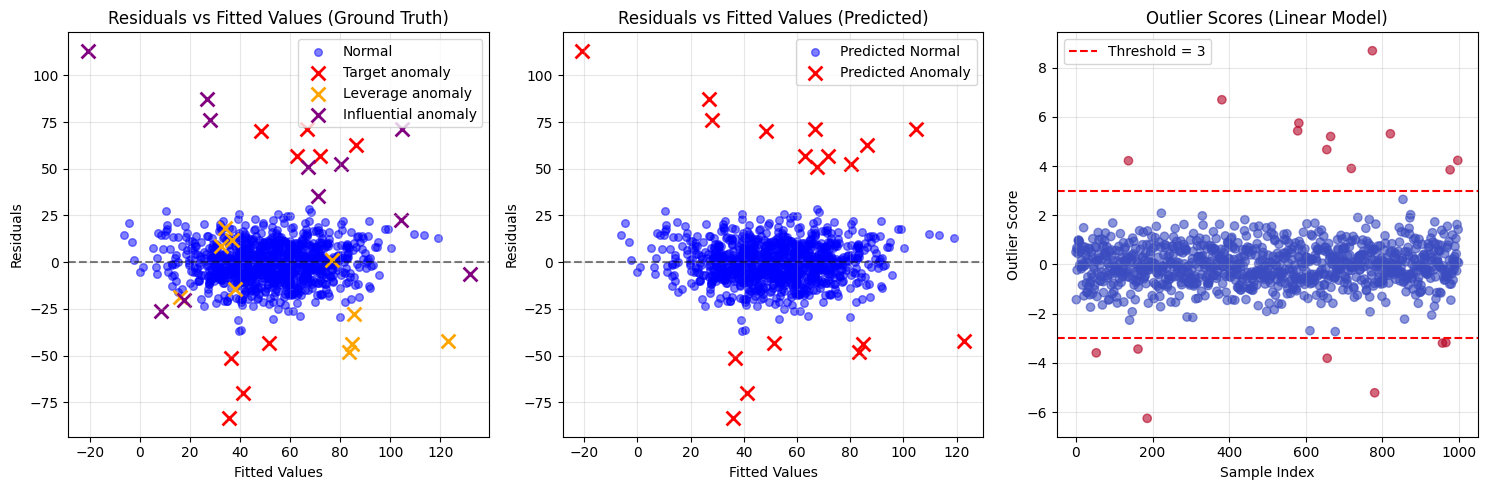

In [5]:
# Ensure we have the results DataFrame
if 'df_results_linear' not in locals() or df_results_linear is None:
    raise SystemExit("Prediction results are not available for evaluation.")
if 'IS_OUTLIER' not in df_results_linear.columns:
    raise SystemExit("Required 'IS_OUTLIER' column not found in prediction results for evaluation.")

# Merge predictions with the original local data (which has the ground truth)
print("\nMerging predictions with ground truth...")
df_merged_linear = pd.merge(
    df_local[['ID', TRUTH_COL, ANOMALY_TYPE_COL] + FEATURE_COLS + [TARGET_COL]], 
    df_results_linear[['ID', 'IS_OUTLIER', 'OUTLIER_SCORE', 'RESIDUAL']],
    on='ID', 
    how='left'
)

# Rename IS_OUTLIER to predicted_anomaly for consistency
df_merged_linear.rename(columns={'IS_OUTLIER': 'predicted_anomaly'}, inplace=True)

print("\nMerged DataFrame Head (with truth and prediction):")
print(df_merged_linear[['ID', TRUTH_COL, 'predicted_anomaly', 'OUTLIER_SCORE', 'RESIDUAL']].head())

# --- Performance Metrics ---
print("\n--- Classification Report (Linear Model) ---")
print(classification_report(df_merged_linear[TRUTH_COL], df_merged_linear['predicted_anomaly'], 
                          target_names=['Normal (0)', 'Anomaly (1)']))

print("\n--- Confusion Matrix (Linear Model) ---")
cm_linear = confusion_matrix(df_merged_linear[TRUTH_COL], df_merged_linear['predicted_anomaly'])
print(cm_linear)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_linear, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Normal', 'Predicted Anomaly'], 
            yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Linear Model)')
plt.show()

# --- Residual Plot with Anomalies ---
print("\n--- Plotting Residuals: Ground Truth vs. Predicted Anomalies (Linear Model) ---")
plt.figure(figsize=(15, 5))

# Subplot 1: Residual vs Fitted Values
plt.subplot(1, 3, 1)
# Calculate fitted values
fitted_values = df_merged_linear[TARGET_COL] - df_merged_linear['RESIDUAL']

# Plot normal points
normal_mask = df_merged_linear[TRUTH_COL] == 0
plt.scatter(fitted_values[normal_mask], df_merged_linear.loc[normal_mask, 'RESIDUAL'], 
           c='blue', alpha=0.5, label='Normal', s=30)

# Plot different anomaly types
colors = {'target': 'red', 'leverage': 'orange', 'influential': 'purple'}
for atype, color in colors.items():
    mask = df_merged_linear[ANOMALY_TYPE_COL] == atype
    if mask.any():
        plt.scatter(fitted_values[mask], df_merged_linear.loc[mask, 'RESIDUAL'], 
                   c=color, label=f'{atype.capitalize()} anomaly', 
                   s=100, marker='x', linewidth=2)

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Ground Truth)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Predicted anomalies
plt.subplot(1, 3, 2)
plt.scatter(fitted_values[normal_mask], df_merged_linear.loc[normal_mask, 'RESIDUAL'], 
           c='blue', alpha=0.5, label='Predicted Normal', s=30)

pred_anomaly_mask = df_merged_linear['predicted_anomaly'] == 1
plt.scatter(fitted_values[pred_anomaly_mask], df_merged_linear.loc[pred_anomaly_mask, 'RESIDUAL'], 
           c='red', label='Predicted Anomaly', s=100, marker='x', linewidth=2)

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Predicted)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Outlier scores
plt.subplot(1, 3, 3)
plt.scatter(range(len(df_merged_linear)), df_merged_linear['OUTLIER_SCORE'], 
           c=df_merged_linear['predicted_anomaly'], cmap='coolwarm', alpha=0.6)
plt.axhline(y=3, color='red', linestyle='--', label='Threshold = 3')
plt.axhline(y=-3, color='red', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Outlier Score')
plt.title('Outlier Scores (Linear Model)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Running Outlier Detection with Tree Regression Model

Now let's try the tree-based regression model.

OutlierDetectionRegression model instantiated (tree model)

Running fit_predict for regression outlier detection (tree model)...
fit_predict completed successfully.

Prediction Results (Tree Model - Head):
   ID     TARGET   RESIDUAL  OUTLIER_SCORE  IS_OUTLIER
0   0  66.783489   7.376023       0.947843           0
1   1  21.166725 -17.287716      -2.246710           0
2   2  44.812290   4.892597       0.626180           0
3   3  36.298686   1.354769       0.167945           0
4   4  82.841295   4.100455       0.523578           0

--- Classification Report (Tree Model) ---
              precision    recall  f1-score   support

  Normal (0)       0.98      1.00      0.99       970
 Anomaly (1)       0.90      0.30      0.45        30

    accuracy                           0.98      1000
   macro avg       0.94      0.65      0.72      1000
weighted avg       0.98      0.98      0.97      1000


--- Confusion Matrix (Tree Model) ---
[[969   1]
 [ 21   9]]


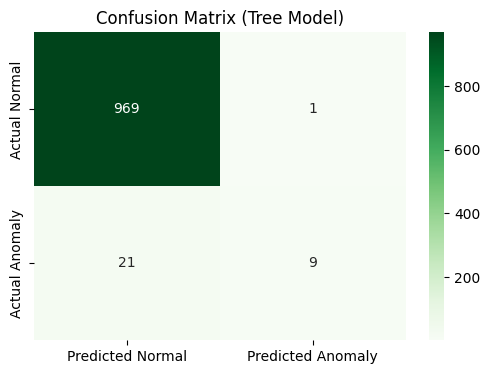

In [6]:
# Instantiate the OutlierDetectionRegression model with tree regression
odr_tree = OutlierDetectionRegression(
    regression_model='tree',
    threshold=3.0,
    iter_num=10,      # Number of trees
    max_depth=6,      # Maximum depth of each tree
    eta=0.3           # Learning rate
)

print("OutlierDetectionRegression model instantiated (tree model)")

# Run fit_predict
print("\nRunning fit_predict for regression outlier detection (tree model)...")
try:
    results_tree_hdf = odr_tree.fit_predict(
        data=hdf_input,
        key='ID',
        features=FEATURE_COLS,
        label=TARGET_COL
    )
    print("fit_predict completed successfully.")

    # Collect and process results
    if results_tree_hdf:
        df_results_tree = results_tree_hdf.collect()
        print("\nPrediction Results (Tree Model - Head):")
        print(df_results_tree.head())
        
        # Evaluate
        df_merged_tree = pd.merge(
            df_local[['ID', TRUTH_COL, ANOMALY_TYPE_COL] + FEATURE_COLS + [TARGET_COL]], 
            df_results_tree[['ID', 'IS_OUTLIER', 'OUTLIER_SCORE', 'RESIDUAL']],
            on='ID', 
            how='left'
        )
        df_merged_tree.rename(columns={'IS_OUTLIER': 'predicted_anomaly'}, inplace=True)
        
        print("\n--- Classification Report (Tree Model) ---")
        print(classification_report(df_merged_tree[TRUTH_COL], df_merged_tree['predicted_anomaly'], 
                                  target_names=['Normal (0)', 'Anomaly (1)']))
        
        print("\n--- Confusion Matrix (Tree Model) ---")
        cm_tree = confusion_matrix(df_merged_tree[TRUTH_COL], df_merged_tree['predicted_anomaly'])
        print(cm_tree)
        
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens', 
                    xticklabels=['Predicted Normal', 'Predicted Anomaly'], 
                    yticklabels=['Actual Normal', 'Actual Anomaly'])
        plt.title('Confusion Matrix (Tree Model)')
        plt.show()
        
    else:
        print("fit_predict (Tree Model) did not return results.")

except Exception as e:
    print(f"Error during fit_predict (Tree Model): {e}")

## 5. Experimenting with Different Thresholds

Let's see how different threshold values affect the results.


Testing threshold = 2.0
  Precision: 0.714, Recall: 0.667, F1: 0.690
  Predicted outliers: 28

Testing threshold = 2.5
  Precision: 0.905, Recall: 0.633, F1: 0.745
  Predicted outliers: 21

Testing threshold = 3.0
  Precision: 1.000, Recall: 0.600, F1: 0.750
  Predicted outliers: 18

Testing threshold = 3.5
  Precision: 1.000, Recall: 0.500, F1: 0.667
  Predicted outliers: 15

Testing threshold = 4.0
  Precision: 1.000, Recall: 0.367, F1: 0.537
  Predicted outliers: 11


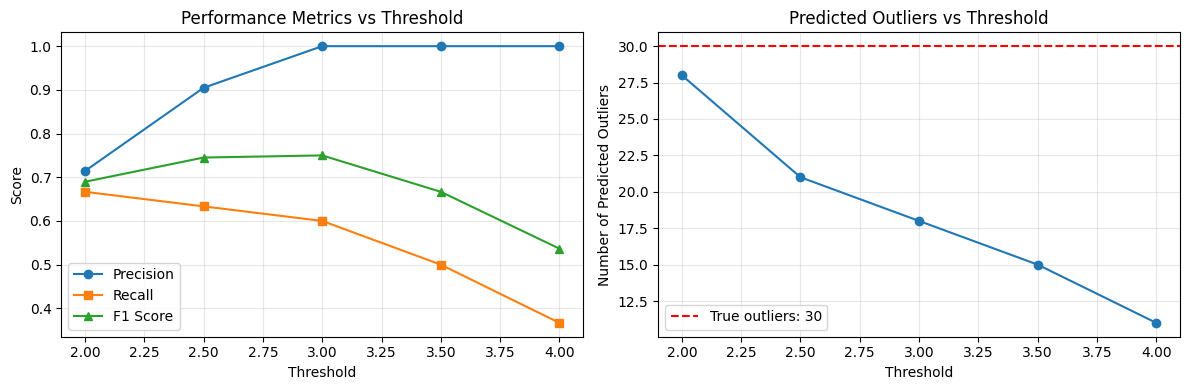

In [7]:
# Try different threshold values for linear model
thresholds = [2.0, 2.5, 3.0, 3.5, 4.0]
threshold_results = []

for threshold in thresholds:
    print(f"\nTesting threshold = {threshold}")
    
    # Create model with current threshold
    odr_thresh = OutlierDetectionRegression(
        regression_model='linear',
        threshold=threshold
    )
    
    try:
        # Run prediction
        results_thresh_hdf = odr_thresh.fit_predict(
            data=hdf_input,
            key='ID',
            features=FEATURE_COLS,
            label=TARGET_COL
        )
        
        # Collect results
        df_results_thresh = results_thresh_hdf.collect()
        
        # Calculate metrics
        df_merged_thresh = pd.merge(
            df_local[['ID', TRUTH_COL]], 
            df_results_thresh[['ID', 'IS_OUTLIER']],
            on='ID', 
            how='left'
        )
        
        # Calculate precision, recall, f1
        from sklearn.metrics import precision_score, recall_score, f1_score
        
        precision = precision_score(df_merged_thresh[TRUTH_COL], df_merged_thresh['IS_OUTLIER'])
        recall = recall_score(df_merged_thresh[TRUTH_COL], df_merged_thresh['IS_OUTLIER'])
        f1 = f1_score(df_merged_thresh[TRUTH_COL], df_merged_thresh['IS_OUTLIER'])
        
        threshold_results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'n_predicted_outliers': df_merged_thresh['IS_OUTLIER'].sum()
        })
        
        print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
        print(f"  Predicted outliers: {df_merged_thresh['IS_OUTLIER'].sum()}")
        
    except Exception as e:
        print(f"  Error with threshold {threshold}: {e}")

# Plot threshold analysis
if threshold_results:
    df_thresh_analysis = pd.DataFrame(threshold_results)
    
    plt.figure(figsize=(12, 4))
    
    # Plot 1: Metrics vs Threshold
    plt.subplot(1, 2, 1)
    plt.plot(df_thresh_analysis['threshold'], df_thresh_analysis['precision'], 'o-', label='Precision')
    plt.plot(df_thresh_analysis['threshold'], df_thresh_analysis['recall'], 's-', label='Recall')
    plt.plot(df_thresh_analysis['threshold'], df_thresh_analysis['f1_score'], '^-', label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Performance Metrics vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Number of predicted outliers
    plt.subplot(1, 2, 2)
    plt.plot(df_thresh_analysis['threshold'], df_thresh_analysis['n_predicted_outliers'], 'o-')
    plt.axhline(y=df_local[TRUTH_COL].sum(), color='red', linestyle='--', 
                label=f'True outliers: {df_local[TRUTH_COL].sum()}')
    plt.xlabel('Threshold')
    plt.ylabel('Number of Predicted Outliers')
    plt.title('Predicted Outliers vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5.1 Z-Score Threshold Tuning for Tree Model

Let's also demonstrate threshold tuning specifically for the tree model to understand z-score thresholds.


--- Z-Score Threshold Analysis for Tree Model ---

Testing z-score threshold = 1.5
  Precision: 0.128, Recall: 0.500, F1: 0.204
  Predicted outliers: 117
  Normal distribution coverage: 86.64%

Testing z-score threshold = 2.0
  Precision: 0.256, Recall: 0.333, F1: 0.290
  Predicted outliers: 39
  Normal distribution coverage: 95.45%

Testing z-score threshold = 2.5
  Precision: 0.667, Recall: 0.333, F1: 0.444
  Predicted outliers: 15
  Normal distribution coverage: 98.76%

Testing z-score threshold = 3.0
  Precision: 0.900, Recall: 0.300, F1: 0.450
  Predicted outliers: 10
  Normal distribution coverage: 99.73%

Testing z-score threshold = 3.5
  Precision: 1.000, Recall: 0.200, F1: 0.333
  Predicted outliers: 6
  Normal distribution coverage: 99.95%

Testing z-score threshold = 4.0
  Precision: 1.000, Recall: 0.167, F1: 0.286
  Predicted outliers: 5
  Normal distribution coverage: 99.99%


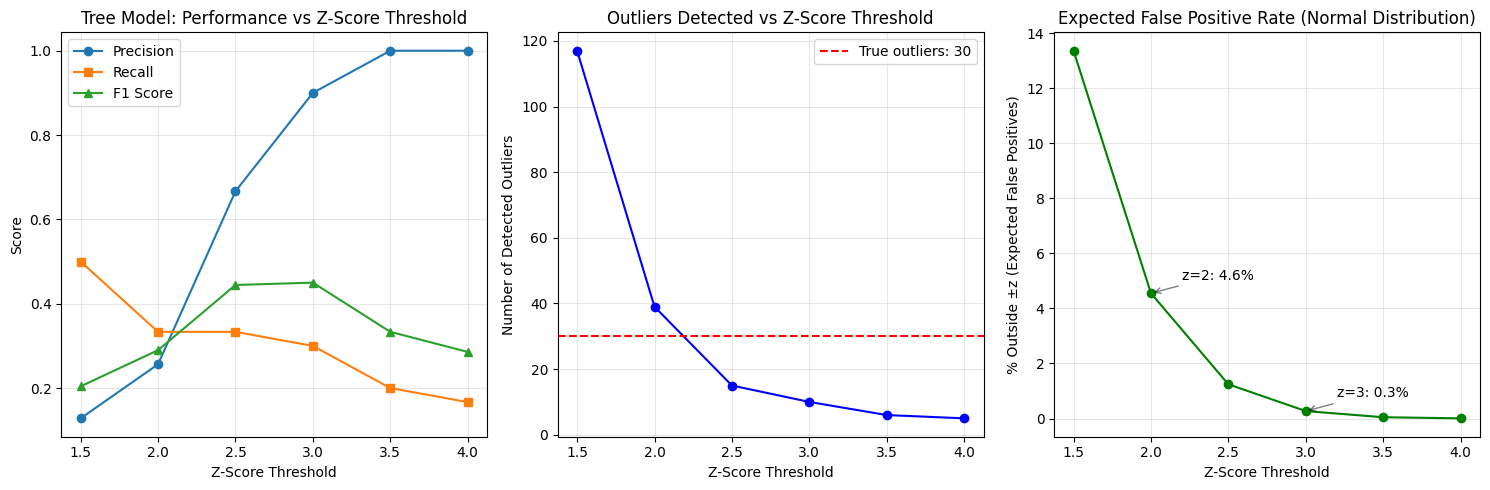

In [9]:
import scipy.stats as stats
# Try different z-score thresholds for tree model
z_score_thresholds = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
tree_threshold_results = []

print("\n--- Z-Score Threshold Analysis for Tree Model ---")
for z_threshold in z_score_thresholds:
    print(f"\nTesting z-score threshold = {z_threshold}")
    
    # Create tree model with current threshold
    odr_tree_thresh = OutlierDetectionRegression(
        regression_model='tree',
        threshold=z_threshold,
        iter_num=10,
        max_depth=6,
        eta=0.3
    )
    
    try:
        # Run prediction
        results_tree_thresh_hdf = odr_tree_thresh.fit_predict(
            data=hdf_input,
            key='ID',
            features=FEATURE_COLS,
            label=TARGET_COL
        )
        
        # Collect results
        df_results_tree_thresh = results_tree_thresh_hdf.collect()
        
        # Calculate metrics
        df_merged_tree_thresh = pd.merge(
            df_local[['ID', TRUTH_COL]], 
            df_results_tree_thresh[['ID', 'IS_OUTLIER']],
            on='ID', 
            how='left'
        )
        
        # Calculate metrics
        precision = precision_score(df_merged_tree_thresh[TRUTH_COL], df_merged_tree_thresh['IS_OUTLIER'])
        recall = recall_score(df_merged_tree_thresh[TRUTH_COL], df_merged_tree_thresh['IS_OUTLIER'])
        f1 = f1_score(df_merged_tree_thresh[TRUTH_COL], df_merged_tree_thresh['IS_OUTLIER'])
        
        tree_threshold_results.append({
            'z_threshold': z_threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'n_predicted_outliers': df_merged_tree_thresh['IS_OUTLIER'].sum(),
            'normal_dist_coverage': 2 * (1 - stats.norm.cdf(z_threshold)) * 100  # Percentage outside ±z
        })
        
        print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
        print(f"  Predicted outliers: {df_merged_tree_thresh['IS_OUTLIER'].sum()}")
        print(f"  Normal distribution coverage: {100 - tree_threshold_results[-1]['normal_dist_coverage']:.2f}%")
        
    except Exception as e:
        print(f"  Error with z-score threshold {z_threshold}: {e}")

# Visualize z-score threshold analysis
if tree_threshold_results:
    df_tree_thresh = pd.DataFrame(tree_threshold_results)
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Performance metrics
    plt.subplot(1, 3, 1)
    plt.plot(df_tree_thresh['z_threshold'], df_tree_thresh['precision'], 'o-', label='Precision')
    plt.plot(df_tree_thresh['z_threshold'], df_tree_thresh['recall'], 's-', label='Recall')
    plt.plot(df_tree_thresh['z_threshold'], df_tree_thresh['f1_score'], '^-', label='F1 Score')
    plt.xlabel('Z-Score Threshold')
    plt.ylabel('Score')
    plt.title('Tree Model: Performance vs Z-Score Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Outlier count vs threshold
    plt.subplot(1, 3, 2)
    plt.plot(df_tree_thresh['z_threshold'], df_tree_thresh['n_predicted_outliers'], 'o-', color='blue')
    plt.axhline(y=df_local[TRUTH_COL].sum(), color='red', linestyle='--', 
                label=f'True outliers: {df_local[TRUTH_COL].sum()}')
    plt.xlabel('Z-Score Threshold')
    plt.ylabel('Number of Detected Outliers')
    plt.title('Outliers Detected vs Z-Score Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Normal distribution coverage
    plt.subplot(1, 3, 3)
    plt.plot(df_tree_thresh['z_threshold'], df_tree_thresh['normal_dist_coverage'], 'o-', color='green')
    plt.xlabel('Z-Score Threshold')
    plt.ylabel('% Outside ±z (Expected False Positives)')
    plt.title('Expected False Positive Rate (Normal Distribution)')
    plt.grid(True, alpha=0.3)
    
    # Add annotations for common thresholds
    for z in [2, 3]:
        idx = df_tree_thresh[df_tree_thresh['z_threshold'] == z].index
        if len(idx) > 0:
            pct = df_tree_thresh.loc[idx[0], 'normal_dist_coverage']
            plt.annotate(f'z={z}: {pct:.1f}%', 
                        xy=(z, pct), xytext=(z+0.2, pct+0.5),
                        arrowprops=dict(arrowstyle='->', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

## 6. Understanding Z-Score Threshold in Tree Model

Let's examine how the z-score threshold works in the tree model.


--- Understanding Z-Score Outlier Detection (Tree Model) ---
Residual Statistics:
  Mean: 0.0581
  Std Dev: 7.7206
  Threshold used: 3.0


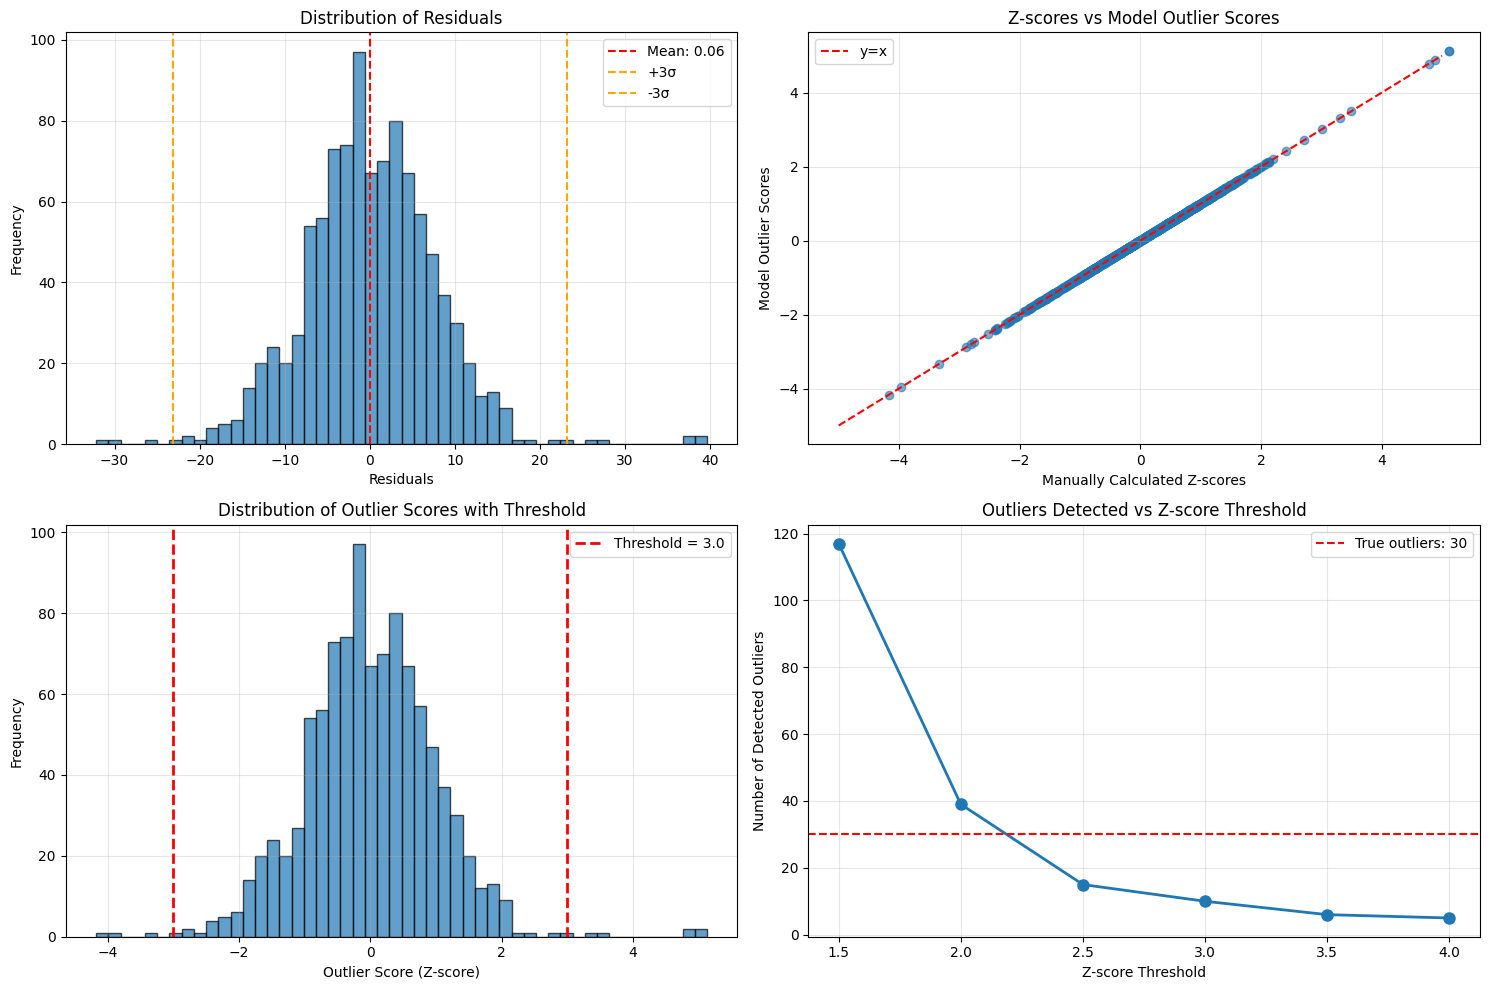


--- Examples of Z-score Based Detection ---
Samples with |z-score| > 3.0 (detected as outliers):
      ID   RESIDUAL  OUTLIER_SCORE  predicted_anomaly  is_anomaly anomaly_type
137  137  37.003436       4.785313                  1           1       target
186  186 -32.158079      -4.172783                  1           1       target
579  579  27.023265       3.492639                  1           1  influential
655  655  37.774532       4.885189                  1           1       target
656  656 -25.761438      -3.344263                  1           1       target

--- Z-score Threshold Interpretation ---
For Tree Model:
- threshold = 2.0 → Points with |z-score| > 2 are outliers (~95.4% of normal distribution)
- threshold = 2.5 → Points with |z-score| > 2.5 are outliers (~98.8% of normal distribution)
- threshold = 3.0 → Points with |z-score| > 3 are outliers (~99.7% of normal distribution)
- threshold = 3.5 → Points with |z-score| > 3.5 are outliers (~99.95% of normal distribution)


In [10]:
if 'df_merged_tree' in locals():
    print("\n--- Understanding Z-Score Outlier Detection (Tree Model) ---")
    
    # Calculate z-scores manually to verify
    residuals = df_merged_tree['RESIDUAL']
    residual_mean = residuals.mean()
    residual_std = residuals.std()
    
    # Calculate z-scores
    z_scores_manual = (residuals - residual_mean) / residual_std
    
    # Compare with outlier scores from the model
    print(f"Residual Statistics:")
    print(f"  Mean: {residual_mean:.4f}")
    print(f"  Std Dev: {residual_std:.4f}")
    print(f"  Threshold used: {3.0}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Distribution of residuals
    axes[0, 0].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(residual_mean, color='red', linestyle='--', label=f'Mean: {residual_mean:.2f}')
    axes[0, 0].axvline(residual_mean + 3*residual_std, color='orange', linestyle='--', label='+3σ')
    axes[0, 0].axvline(residual_mean - 3*residual_std, color='orange', linestyle='--', label='-3σ')
    axes[0, 0].set_xlabel('Residuals')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Residuals')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Z-scores vs Outlier Scores
    axes[0, 1].scatter(z_scores_manual, df_merged_tree['OUTLIER_SCORE'], alpha=0.6)
    axes[0, 1].plot([-5, 5], [-5, 5], 'r--', label='y=x')
    axes[0, 1].set_xlabel('Manually Calculated Z-scores')
    axes[0, 1].set_ylabel('Model Outlier Scores')
    axes[0, 1].set_title('Z-scores vs Model Outlier Scores')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Z-score distribution with threshold
    axes[1, 0].hist(df_merged_tree['OUTLIER_SCORE'], bins=50, alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(3.0, color='red', linestyle='--', linewidth=2, label='Threshold = 3.0')
    axes[1, 0].axvline(-3.0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Outlier Score (Z-score)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Outlier Scores with Threshold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Effect of different thresholds
    thresholds_demo = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
    outlier_counts = []
    
    for thresh in thresholds_demo:
        count = (np.abs(df_merged_tree['OUTLIER_SCORE']) > thresh).sum()
        outlier_counts.append(count)
    
    axes[1, 1].plot(thresholds_demo, outlier_counts, 'o-', markersize=8, linewidth=2)
    axes[1, 1].axhline(y=df_merged_tree[TRUTH_COL].sum(), color='red', linestyle='--', 
                       label=f'True outliers: {df_merged_tree[TRUTH_COL].sum()}')
    axes[1, 1].set_xlabel('Z-score Threshold')
    axes[1, 1].set_ylabel('Number of Detected Outliers')
    axes[1, 1].set_title('Outliers Detected vs Z-score Threshold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show specific examples
    print("\n--- Examples of Z-score Based Detection ---")
    print("Samples with |z-score| > 3.0 (detected as outliers):")
    outlier_examples = df_merged_tree[df_merged_tree['predicted_anomaly'] == 1].head(5)
    print(outlier_examples[['ID', 'RESIDUAL', 'OUTLIER_SCORE', 'predicted_anomaly', TRUTH_COL, ANOMALY_TYPE_COL]])
    
    print("\n--- Z-score Threshold Interpretation ---")
    print("For Tree Model:")
    print("- threshold = 2.0 → Points with |z-score| > 2 are outliers (~95.4% of normal distribution)")
    print("- threshold = 2.5 → Points with |z-score| > 2.5 are outliers (~98.8% of normal distribution)")
    print("- threshold = 3.0 → Points with |z-score| > 3 are outliers (~99.7% of normal distribution)")
    print("- threshold = 3.5 → Points with |z-score| > 3.5 are outliers (~99.95% of normal distribution)")

## 6.1 Feature Importance Analysis (Tree Model)

For the tree model, we can analyze which features contribute most to outlier detection.


--- Feature Analysis for Outlier Detection ---


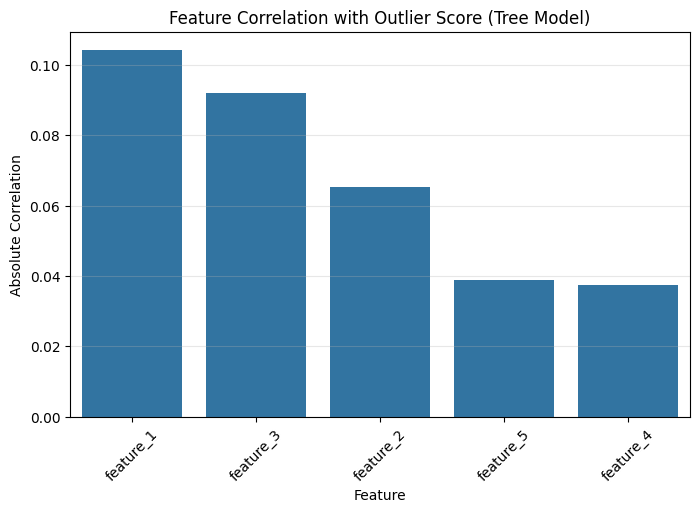


Feature correlations with outlier score:
     feature  correlation
0  feature_1     0.104187
2  feature_3     0.091907
1  feature_2     0.065447
4  feature_5     0.038754
3  feature_4     0.037496


In [11]:
# If we have tree model results, let's analyze feature importance through residuals
if 'df_merged_tree' in locals():
    print("\n--- Feature Analysis for Outlier Detection ---")
    
    # Calculate correlation between features and outlier scores
    feature_outlier_corr = []
    for feat in FEATURE_COLS:
        corr = np.abs(df_merged_tree[feat].corr(df_merged_tree['OUTLIER_SCORE']))
        feature_outlier_corr.append({'feature': feat, 'correlation': corr})
    
    df_feat_corr = pd.DataFrame(feature_outlier_corr).sort_values('correlation', ascending=False)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_feat_corr, x='feature', y='correlation')
    plt.title('Feature Correlation with Outlier Score (Tree Model)')
    plt.ylabel('Absolute Correlation')
    plt.xlabel('Feature')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    plt.show()
    
    print("\nFeature correlations with outlier score:")
    print(df_feat_corr)

## 7. Comparing Linear vs Tree Models

Let's compare the performance of both models.


--- Model Comparison: Linear vs Tree ---
    Model  Accuracy  Precision  Recall  F1 Score
0  Linear     0.988        1.0     0.6      0.75
1    Tree     0.978        0.9     0.3      0.45


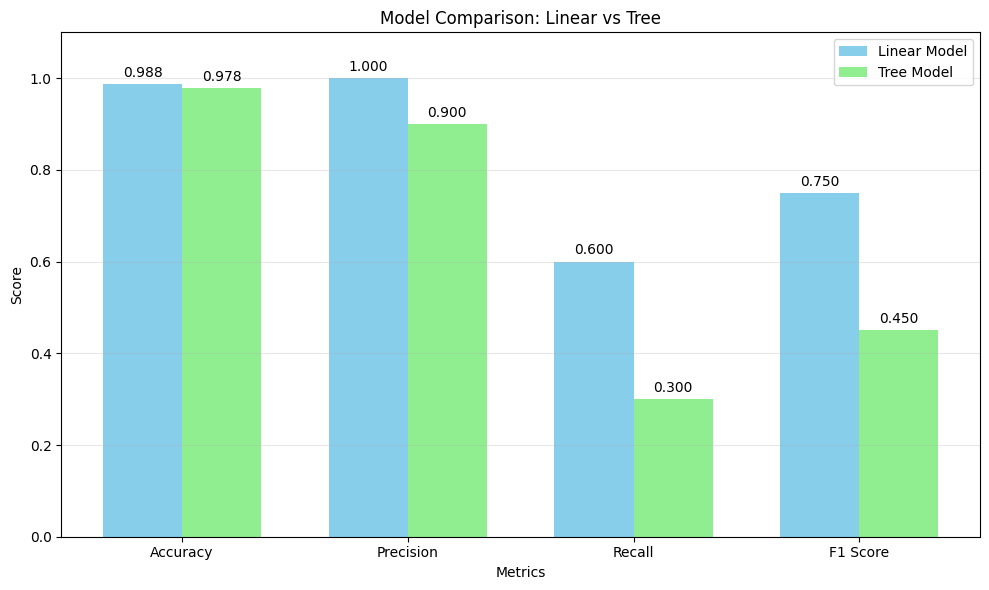


--- Performance by Anomaly Type (Linear Model) ---
Target anomalies - Recall: 1.000 (9/9 detected)
Leverage anomalies - Recall: 0.300 (3/10 detected)
Influential anomalies - Recall: 0.545 (6/11 detected)


In [12]:
if 'df_merged_linear' in locals() and 'df_merged_tree' in locals():
    print("\n--- Model Comparison: Linear vs Tree ---")
    
    # Calculate metrics for both models
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    models_comparison = []
    
    # Linear model metrics
    models_comparison.append({
        'Model': 'Linear',
        'Accuracy': accuracy_score(df_merged_linear[TRUTH_COL], df_merged_linear['predicted_anomaly']),
        'Precision': precision_score(df_merged_linear[TRUTH_COL], df_merged_linear['predicted_anomaly']),
        'Recall': recall_score(df_merged_linear[TRUTH_COL], df_merged_linear['predicted_anomaly']),
        'F1 Score': f1_score(df_merged_linear[TRUTH_COL], df_merged_linear['predicted_anomaly'])
    })
    
    # Tree model metrics
    models_comparison.append({
        'Model': 'Tree',
        'Accuracy': accuracy_score(df_merged_tree[TRUTH_COL], df_merged_tree['predicted_anomaly']),
        'Precision': precision_score(df_merged_tree[TRUTH_COL], df_merged_tree['predicted_anomaly']),
        'Recall': recall_score(df_merged_tree[TRUTH_COL], df_merged_tree['predicted_anomaly']),
        'F1 Score': f1_score(df_merged_tree[TRUTH_COL], df_merged_tree['predicted_anomaly'])
    })
    
    df_comparison = pd.DataFrame(models_comparison)
    print(df_comparison)
    
    # Visualize comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    linear_scores = df_comparison[df_comparison['Model'] == 'Linear'][metrics].values[0]
    tree_scores = df_comparison[df_comparison['Model'] == 'Tree'][metrics].values[0]
    
    bars1 = ax.bar(x - width/2, linear_scores, width, label='Linear Model', color='skyblue')
    bars2 = ax.bar(x + width/2, tree_scores, width, label='Tree Model', color='lightgreen')
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('Model Comparison: Linear vs Tree')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim(0, 1.1)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Performance by anomaly type
    print("\n--- Performance by Anomaly Type (Linear Model) ---")
    for atype in ['target', 'leverage', 'influential']:
        mask = df_merged_linear[ANOMALY_TYPE_COL] == atype
        if mask.any():
            tp = ((df_merged_linear[TRUTH_COL] == 1) & 
                  (df_merged_linear['predicted_anomaly'] == 1) & mask).sum()
            fn = ((df_merged_linear[TRUTH_COL] == 1) & 
                  (df_merged_linear['predicted_anomaly'] == 0) & mask).sum()
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            print(f"{atype.capitalize()} anomalies - Recall: {recall:.3f} ({tp}/{tp+fn} detected)")

## 8. Cleanup

Finally, let's remove the table we created in HANA.

In [13]:
print("\n--- Cleaning up HANA tables ---")
tables_to_drop = [TABLE_NAME]

for table in tables_to_drop:
    try:
        cc.drop_table(table)
        print(f"Dropped table: {table}")
    except Exception as e:
        print(f"Could not drop table {table} (may not exist or permissions issue): {e}")

# Close the connection
try:
    cc.close()
    print("\nHANA connection closed.")
except Exception as e:
    print(f"Error closing connection: {e}")


--- Cleaning up HANA tables ---
Dropped table: SYNTHETIC_REGRESSION_ANOMALY_DATA

HANA connection closed.
